*URN: 6779396, Username: mk0217*

**COM2028 ARTIFICIAL INTELLIGENCE, SEMESTER 2
2023-24, Individual Coursework**

---




Downloading the dataset:

In [ ]:
!pip install medmnist

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.4/88.4 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached 

In [ ]:
from tqdm import tqdm

# Calculations
import numpy as np
from sklearn.metrics import accuracy_score

# Pytorch
import torch
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import torch.nn.functional as F

# BreastMNIST
import medmnist
from medmnist import INFO, Evaluator

In [ ]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.1 @ https://github.com/MedMNIST/MedMNIST/


In [ ]:
data_flag = 'breastmnist'
download = True

info = INFO[data_flag]
task = info['task']
in_channels = 1
info['n_channels']
num_of_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

Rereading and preprocessing MedMNIST data:

In [ ]:
# Preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

### **Deliverable 1**

Building a new model based on ResNet-18:

In [ ]:
class Net(nn.Module):

  # Initialise Net class
  def __init__(self, in_channels, num_of_classes):
    super(Net, self).__init__()

    # Load in ResNet-18, with pretrained as True to benefit from pre-trained weights
    self.resnet18 = models.resnet18(pretrained=True)

    # Ensure in_channels(1) is applied on first layer
    self.resnet18.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

    # Freeze layers (freezing layers will save model from overfitting as weights and biases are already pretrained)
    for param in self.resnet18.parameters():
      param.requires_grad = False

    # Retrieve no of input features to final fc layer
    num_of_fc_inputs = self.resnet18.fc.in_features

    # Replace Resnet18's final fc layer with two layers (1 fc layer with ReLU and an output layer of 2 labels (binary class))
    self.resnet18.fc = nn.Sequential(
        nn.Linear(num_of_fc_inputs, 256),
        nn.ReLU(),
        nn.Linear(256, num_of_classes) # No activation function for last layer to prevent interfering with outputs
    )

  # Define Forward method
  def forward(self, x):
    return self.resnet18(x)


Splitting BreastMNIST dataset into train, validation and test sets:



In [ ]:
# Set moderate batch size considering memory but also efficient training
BATCH_SIZE = 64

# Split BreastMNIST dataset into train, validation and test sets using its python DataClass
# DataClass splits BreastMNIST dataset into a 7:1:2 ratio for train (546), val (78) and test (156)
train_dataset = DataClass(split='train', transform=data_transform, download=download)
val_dataset = DataClass(split='val', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

# Encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

print(train_dataset)
print("===================")
print(val_dataset)
print("===================")
print(test_dataset)


Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Using downloaded and verified file: /root/.medmnist/breastmnist.npz
Dataset BreastMNIST of size 28 (breastmnist)
    Number of datapoints: 546
    Root location: /root/.medmnist
    Split: train
    Task: binary-class
    Number of channels: 1
    Meaning of labels: {'0': 'malignant', '1': 'normal, benign'}
    Number of samples: {'train': 546, 'val': 78, 'test': 156}
    Description: The BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign, and malignant. As we use low-resolution images, we simplify the task into binary classification by combining normal and benign as positive and classifying them against malignant as negative. We split the source dataset with a ratio of 7:1:2 into training, validation and test set. The source images of 1×500×500 are resized into 1×28×28.
    License: CC B

Use validation set to select the most optimal hyperparameters (through grid search):

In [ ]:
# Initialise best accuracy and best hyperparameters
best_accuracy = 0
best_hps = {}

# Define hyperparameters to evaluate (learning rates, num of epochs and optimisers):
learning_rates = [0.1, 0.01, 0.001, 0.0001]
optimisers = [optim.SGD, optim.Adam]
num_of_epochs = [10, 20, 30, 40]

# Selecting the best hyperparameters through grid search:
for learning_rate in learning_rates:
  for each_optimiser in optimisers:
    for each_epoch in num_of_epochs:

      # Create instance of model
      model = Net(in_channels=in_channels, num_of_classes=num_of_classes)

      # Define optimiser
      optimizer = each_optimiser(model.parameters(), lr = learning_rate)

      # Define loss function
      criterion = nn.CrossEntropyLoss()

      # Train model for each number of epochs defined
      for epoch in range(each_epoch):
        model.train()

        for inputs, targets in tqdm(train_loader, desc = "Epoch-" + str(epoch)):
          optimizer.zero_grad() # Reset optimizer's gradient to zero
          outputs = model(inputs) # Forward pass
          targets = targets.squeeze() # Format targets tensor into correct shape (1D tensor)
          loss = criterion(outputs, targets) # Calculate loss
          loss.backward() # Backpropagate
          optimizer.step() # Update parameters

      # Use validation set
      model.eval()
      pred_targets = [] # Initialise list of predicted targets
      true_targets = [] # Initialise list of true targets

      with torch.no_grad(): # Does not calculate gradients for evaluation
        for inputs, targets in val_loader:
          outputs = model(inputs) # Forward pass
          _, pred_target = torch.max(outputs, 1) # Retrieve predicted targets

          pred_targets.extend(pred_target.tolist()) # Collect each predicted target into list
          true_targets.extend(targets.tolist()) # Collect each true target into list

      # Calculate model's accuracy between predicted targets and true targets
      accuracy = accuracy_score(true_targets, pred_targets)

      # Update best_accuracy and best_hps if below condition is true
      if best_accuracy < accuracy:
        best_accuracy = accuracy
        best_hps = {'learning_rate': learning_rate, 'optimizer': each_optimiser.__name__, 'epochs': each_epoch}

print('Selected Hyperparameters: ', best_hps)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch-9: 100%|██████████| 9/9 [00:01<00:00,  5.73it/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other

Selected Hyperparameters:  {'learning_rate': 0.1, 'optimizer': 'SGD', 'epochs': 20}


Train model (using train and val dataset), using the selected hyperparameters:

In [ ]:
# Results after the code above (to select the best hyperparameters through grid search, using the validation set):
# Selected Hyperparameters:  {'learning_rate': 0.1, 'optimizer': 'SGD', 'epochs': 20}

learning_rate = 0.1
epochs = 20

# Create instance of model
model = Net(in_channels=in_channels, num_of_classes=num_of_classes)

# Define loss function and optimiser
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Calculate accuracy between a set of predicted targets (logits) and the true targets (labels)
def accuracy(output, target):
  pred = output.argmax(dim=1, keepdim=True)
  correct = pred.eq(target.view_as(pred)).sum().item()
  return correct / len(target)


# Train
# for loop over epochs
for epoch in range(epochs):
  model.train()

  # Initialise running loss and accuracy under train
  train_loss = 0.0
  train_accuracy = 0.0

  # For loop over mini batches
  for inputs, targets in tqdm(train_loader, desc = "Epoch-" + str(epoch)):
    optimizer.zero_grad() # Reset optimiser's gradient to zero
    outputs = model(inputs) # Forward pass
    targets = targets.squeeze().long() # Format targets into long tensor
    loss = criterion(outputs, targets) # Calculate loss
    loss.backward() # Backpropagate
    optimizer.step() # Update parameters

    # Collect loss and accuracy
    train_loss += loss.item()
    train_accuracy += accuracy(outputs, targets)

  print('Training --> Loss: {:.6f}, Accuracy: {:.3f}%'.format(
      train_loss / len(train_loader), train_accuracy / len(train_loader) * 100))

  # Validate
  model.eval()
  # Initialise running loss and accuracy under validation
  val_loss = 0
  val_accuracy = 0

  with torch.no_grad(): # Does not calculate gradients for evaluation
    for inputs, targets in val_loader:
      outputs = model(inputs) # Forward pass
      targets = targets.squeeze().long() # Format targets into long tensor

      # Collect loss and accuracy
      val_loss += criterion(outputs, targets)
      val_accuracy += accuracy(outputs, targets)

  print('Validation --> Loss: {:.6f}, Accuracy: {:.3f}%\n'.format(
      val_loss / len(val_loader), val_accuracy / len(val_loader) * 100))


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch-0: 100%|██████████| 9/9 [00:01<00:00,  5.26it/s]


Training --> Loss: 0.696878, Accuracy: 65.635%
Validation --> Loss: 0.601234, Accuracy: 73.077%



Epoch-1: 100%|██████████| 9/9 [00:01<00:00,  5.51it/s]


Training --> Loss: 0.570020, Accuracy: 72.947%
Validation --> Loss: 0.604170, Accuracy: 73.077%



Epoch-2: 100%|██████████| 9/9 [00:01<00:00,  5.61it/s]


Training --> Loss: 0.527405, Accuracy: 75.470%
Validation --> Loss: 0.551502, Accuracy: 73.077%



Epoch-3: 100%|██████████| 9/9 [00:01<00:00,  5.65it/s]


Training --> Loss: 0.465966, Accuracy: 77.165%
Validation --> Loss: 0.576897, Accuracy: 73.077%



Epoch-4: 100%|██████████| 9/9 [00:01<00:00,  5.57it/s]


Training --> Loss: 0.478290, Accuracy: 77.747%
Validation --> Loss: 0.554233, Accuracy: 74.359%



Epoch-5: 100%|██████████| 9/9 [00:02<00:00,  3.89it/s]


Training --> Loss: 0.418032, Accuracy: 81.761%
Validation --> Loss: 0.798042, Accuracy: 52.564%



Epoch-6: 100%|██████████| 9/9 [00:02<00:00,  3.88it/s]


Training --> Loss: 0.478381, Accuracy: 77.012%
Validation --> Loss: 0.557516, Accuracy: 67.949%



Epoch-7: 100%|██████████| 9/9 [00:01<00:00,  5.76it/s]


Training --> Loss: 0.369120, Accuracy: 82.261%
Validation --> Loss: 0.537244, Accuracy: 74.359%



Epoch-8: 100%|██████████| 9/9 [00:01<00:00,  5.49it/s]


Training --> Loss: 0.381443, Accuracy: 82.394%
Validation --> Loss: 0.485710, Accuracy: 78.205%



Epoch-9: 100%|██████████| 9/9 [00:01<00:00,  5.32it/s]


Training --> Loss: 0.383645, Accuracy: 81.853%
Validation --> Loss: 0.517198, Accuracy: 74.359%



Epoch-10: 100%|██████████| 9/9 [00:01<00:00,  5.54it/s]


Training --> Loss: 0.396639, Accuracy: 82.394%
Validation --> Loss: 0.497994, Accuracy: 75.641%



Epoch-11: 100%|██████████| 9/9 [00:01<00:00,  5.27it/s]


Training --> Loss: 0.343709, Accuracy: 85.672%
Validation --> Loss: 0.444801, Accuracy: 79.487%



Epoch-12: 100%|██████████| 9/9 [00:02<00:00,  3.98it/s]


Training --> Loss: 0.444449, Accuracy: 75.837%
Validation --> Loss: 0.431385, Accuracy: 78.205%



Epoch-13: 100%|██████████| 9/9 [00:02<00:00,  4.01it/s]


Training --> Loss: 0.297563, Accuracy: 88.103%
Validation --> Loss: 0.457135, Accuracy: 79.487%



Epoch-14: 100%|██████████| 9/9 [00:01<00:00,  5.62it/s]


Training --> Loss: 0.300248, Accuracy: 86.775%
Validation --> Loss: 0.400903, Accuracy: 78.205%



Epoch-15: 100%|██████████| 9/9 [00:01<00:00,  5.43it/s]


Training --> Loss: 0.313790, Accuracy: 86.714%
Validation --> Loss: 0.447602, Accuracy: 78.205%



Epoch-16: 100%|██████████| 9/9 [00:01<00:00,  5.21it/s]


Training --> Loss: 0.242119, Accuracy: 91.708%
Validation --> Loss: 0.511073, Accuracy: 78.205%



Epoch-17: 100%|██████████| 9/9 [00:01<00:00,  5.34it/s]


Training --> Loss: 0.309857, Accuracy: 85.866%
Validation --> Loss: 0.391969, Accuracy: 79.487%



Epoch-18: 100%|██████████| 9/9 [00:01<00:00,  5.69it/s]


Training --> Loss: 0.252751, Accuracy: 89.859%
Validation --> Loss: 0.462955, Accuracy: 74.359%



Epoch-19: 100%|██████████| 9/9 [00:02<00:00,  3.78it/s]


Training --> Loss: 0.232862, Accuracy: 92.402%
Validation --> Loss: 0.398566, Accuracy: 79.487%



Evaluating model with training and testing (with AUC and accuracy calculated):

In [ ]:
# Evaluation

def test(split):
  model.eval()
  pred_targets = torch.tensor([]) # Initialise list of predicted targets
  true_targets = torch.tensor([]) # Initialise list of true targets


  data_loader = train_loader_at_eval if split == 'train' else test_loader

  with torch.no_grad(): # Does not calculate gradients for evaluation
    for inputs, targets in data_loader:
      outputs = model(inputs) # Forward pass
      targets = targets.squeeze().long() # Format targets tensor into correct shape (1D tensor)

      pred_targets = torch.cat((pred_targets, outputs), 0) # Collect each predicted target into list
      true_targets = torch.cat((true_targets, targets), 0) # Collect each true target into list

    true_targets = true_targets.numpy() # Format into numpy
    pred_targets = pred_targets.detach().numpy() # Format into numpy

    evaluator = Evaluator(data_flag, split) # Create instance of evaluator
    metrics = evaluator.evaluate(pred_targets) # Compute evaluation metrics (accuracy and AUC)

    print('%s - AUC: %.3f, Accuracy: %.3f' % (split, *metrics))

print('==> Evaluating...')
test('train')
test('test')

==> Evaluating...
train - AUC: 0.997, Accuracy: 0.971
test - AUC: 0.774, Accuracy: 0.756


### **Deliverable 2**

Performance Measures (computing AUPR, Precision, Recall, F1):

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc

# Define function to compute aupr, precision score, recall score and f1
def compute(model, test_loader):
  model.eval()
  pred_targets = [] # Initialise list of predicted targets
  true_targets = [] # Initialise list of true targets

  with torch.no_grad(): # Does not calculate gradients for evaluation
    for inputs, targets in test_loader:
      outputs = model(inputs) # Forward pass

      true_targets.extend(targets.cpu().numpy()) # Collect each true target into list (using numpy to format)
      pred_targets.extend(outputs[:, 1].cpu().numpy()) # Collect each predicted target into list (using numpy to format)

  # Compute AUPR
  precision, recall, thresholds = precision_recall_curve(true_targets, pred_targets)
  aupr = auc(recall, precision)

  pred_labels = [1 if target >- 0.5 else 0 for target in pred_targets] # Threshold = 0.5

  # Compute precision
  precision = precision_score(true_targets, pred_labels)

  # Compute recall
  recall = recall_score(true_targets, pred_labels)

  # Compute F1
  f1 = f1_score(true_targets, pred_labels)

  return aupr, precision, recall, f1

# Call function to compute all performance measures
aupr, precision, recall, f1 = compute(model, test_loader)

print("AUPR: ", aupr)
print("\nPrecision Score: ", precision)
print("\nRecall Score: ", precision)
print("\nF1 Score: ", precision)

AUPR:  0.8926108698218167

Precision Score:  0.7482993197278912

Recall Score:  0.7482993197278912

F1 Score:  0.7482993197278912


### **Deliverable 3**

Performance Measues (plot ROC curve, PR curve and confusion matrix):

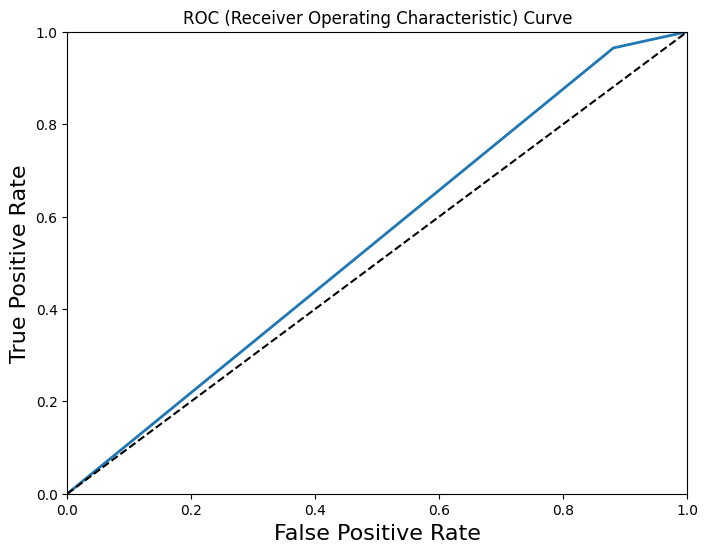

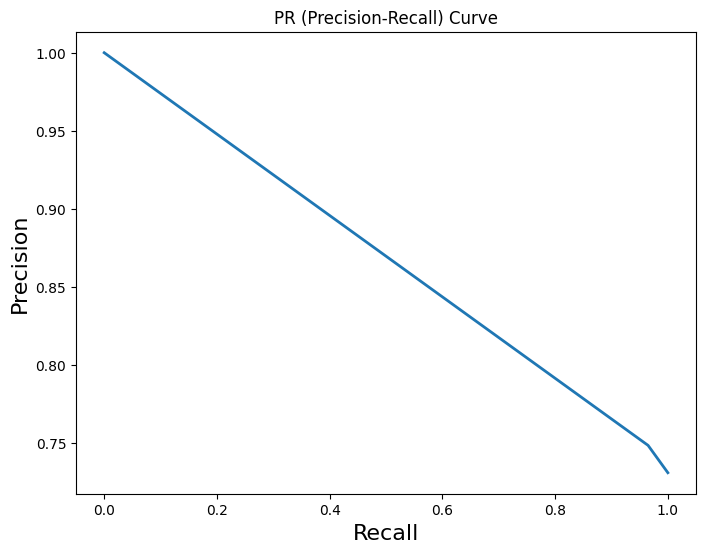

<Figure size 800x600 with 0 Axes>

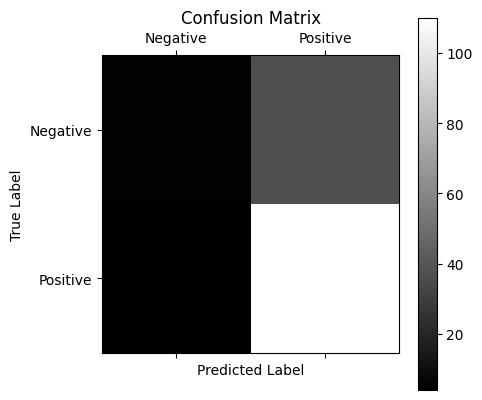

In [ ]:
from sklearn.metrics import roc_curve, precision_recall_curve, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_predict


# Define function to plot ROC curve, PR curve and confusion matrix
def plot_model(model, test_loader):
  model.eval()
  pred_targets = [] # Initialise list of predicted targets
  true_targets = [] # Initialise list of true targets

  with torch.no_grad(): # Does not calculate gradients for evaluation
    for inputs, targets in test_loader:
      outputs = model(inputs) # Forward pass

      true_targets.extend(targets.cpu().numpy()) # Collect each true target into list (using numpy to format)
      pred_targets.extend(outputs[:, 1].cpu().numpy()) # Collect each predicted target into list (using numpy to format)

  pred_labels = [1 if target >- 0.5 else 0 for target in pred_targets] # Threshold = 0.5

  # Compute ROC Curve
  fpr, tpr, thresholds = roc_curve(true_targets, pred_labels) # False Positive Rate, True Positive Rate and Thresholds

  # Plot ROC Curve
  plt.figure(figsize=(8,6))
  plt.title('ROC (Receiver Operating Characteristic) Curve')
  plt.plot(fpr, tpr, linewidth=2, label=None)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.axis([0, 1, 0, 1])
  plt.xlabel('False Positive Rate', fontsize=16)
  plt.ylabel('True Positive Rate', fontsize=16)
  plt.show()

  # Compute PR Curve
  precision, recall, thresholds = precision_recall_curve(true_targets, pred_labels) # Precision, Recall and Thresholds

  # Plot PR Curve
  plt.figure(figsize=(8,6))
  plt.title('PR (Precision-Recall) Curve')
  plt.plot(recall, precision, linewidth=2, label=None)
  plt.xlabel('Recall', fontsize=16)
  plt.ylabel('Precision', fontsize=16)
  plt.show()

  # Compute Confusion Matrix
  conf_mx = confusion_matrix(true_targets, pred_labels)

  # Plot confusion matrix
  plt.figure(figsize=(8, 6))
  plt.matshow(conf_mx, cmap=plt.cm.gray)
  plt.title('Confusion Matrix')
  plt.colorbar()
  plt.xlabel('Predicted Label')
  plt.ylabel('True Label')
  plt.xticks(np.arange(2), ['Negative', 'Positive'])
  plt.yticks(np.arange(2), ['Negative', 'Positive'])
  plt.show()


# Call function to compute and plot all models
plot_model(model, test_loader)





### **Deliverable 4**

Implement 5-fold cross validation:

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Define number of folds in cross validation
k = 5

# Use Stratified K-fold so each fold is representative of overall class distribution
cross_val = StratifiedKFold(n_splits=k, shuffle=True)

# Initialise accuracy list and auc list to store accuracy and auc of each fold
accuracy_list = []
auc_list = []

# For loop over each fold
for fold, (train_ind, val_ind) in enumerate(cross_val.split(range(len(train_dataset)), train_dataset.labels)):
  # Print fold number
  print("===================")
  print(f'Fold {fold + 1}/{k}:\n')

  # Create instance of model
  model = Net(in_channels=1, num_of_classes=2)

  # Define optimiser and loss function
  optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
  criterion = nn.CrossEntropyLoss()

  # Define train sampler and train_loader
  train_sampler = data.SubsetRandomSampler(train_ind)
  train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler )
  # val_loader and test_loader already defined


  # Train
  # For loop over epochs
  for epoch in range(epochs):
    model.train()

    # For loop over mini batches
    for inputs, targets in tqdm(train_loader, desc = "Epoch-" + str(epoch)):
      optimizer.zero_grad() # Reset optimiser's gradient to zero
      outputs = model(inputs) # Forward pass
      targets = targets.squeeze().long() # Format targets into long tensor
      loss = criterion(outputs, targets) # Calculate loss
      loss.backward() # Backpropagate
      optimizer.step() # Update parameters

  # Validate
  model.eval()
  val_pred_targets = []
  val_true_targets = []

  with torch.no_grad(): # Does not calculate gradients for evaluation
    for inputs, targets in val_loader:
      outputs = model(inputs) # Forward pass
      targets = targets.squeeze().long() # Format targets into long tensor

      _, predicted = torch.max(outputs, 1) # Assign predicted targets to 'predicted' and discard maximum values
      val_pred_targets.extend(predicted.tolist()) # Collect each predicted target into list
      val_true_targets.extend(targets.tolist()) # Collect each true target into list

    # Store accuracy and AUC of current epoch in current fold
    accuracy = accuracy_score(val_true_targets, val_pred_targets)
    accuracy_list.append(accuracy)

    auc = roc_auc_score(val_true_targets, val_pred_targets)
    auc_list.append(auc)

    print(f'\nFold {fold + 1}/{k} --> Accuracy: {accuracy}, AUC: {auc}\n')

# Calculate average accuracy and AUC
average_accuracy = sum(accuracy_list)/len(accuracy_list)
average_auc = sum(auc_list)/len(auc_list)

print(f'\nFor all folds --> Average Accuracy: {average_accuracy}, Average AUC: {average_auc}')


Fold 1/5:



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch-19: 100%|██████████| 7/7 [00:01<00:00,  5.67it/s]



Fold 1/5 --> Accuracy: 0.7307692307692307, AUC: 0.6654135338345865

Fold 2/5:



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch-19: 100%|██████████| 7/7 [00:01<00:00,  5.25it/s]



Fold 2/5 --> Accuracy: 0.7692307692307693, AUC: 0.6917293233082706

Fold 3/5:



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch-19: 100%|██████████| 7/7 [00:01<00:00,  5.59it/s]



Fold 3/5 --> Accuracy: 0.8333333333333334, AUC: 0.7656641604010025

Fold 4/5:



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch-19: 100%|██████████| 7/7 [00:01<00:00,  5.73it/s]



Fold 4/5 --> Accuracy: 0.7948717948717948, AUC: 0.7092731829573935

Fold 5/5:



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch-19: 100%|██████████| 7/7 [00:01<00:00,  5.46it/s]



Fold 5/5 --> Accuracy: 0.7692307692307693, AUC: 0.6165413533834586


For all folds --> Average Accuracy: 0.7794871794871795, Average AUC: 0.6897243107769424
